In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sn

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed
/var/folders/b1/p4nglr2j4tldllw81z_d3c4c0000gn/T/ipykernel_39725/4205361466.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df['Close'].resample('M').last()


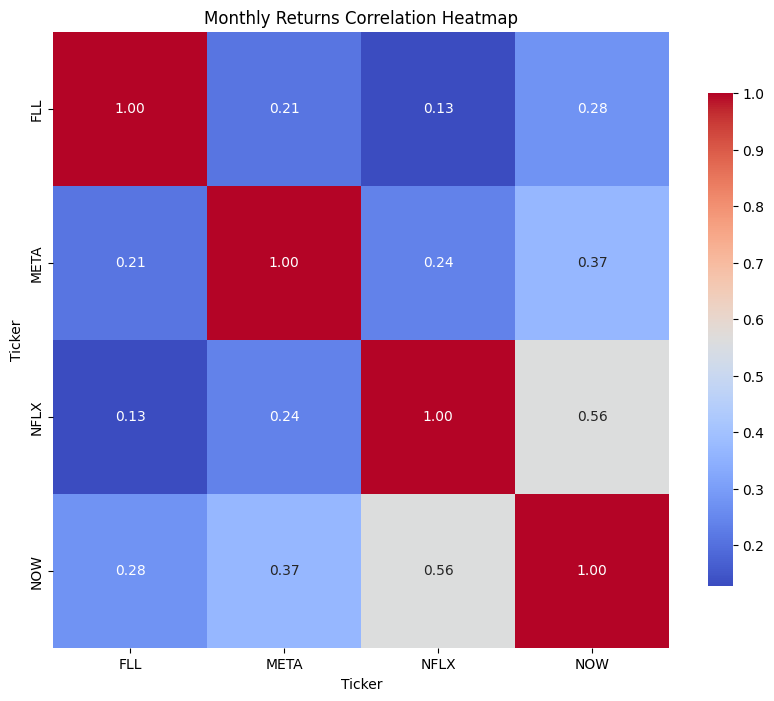

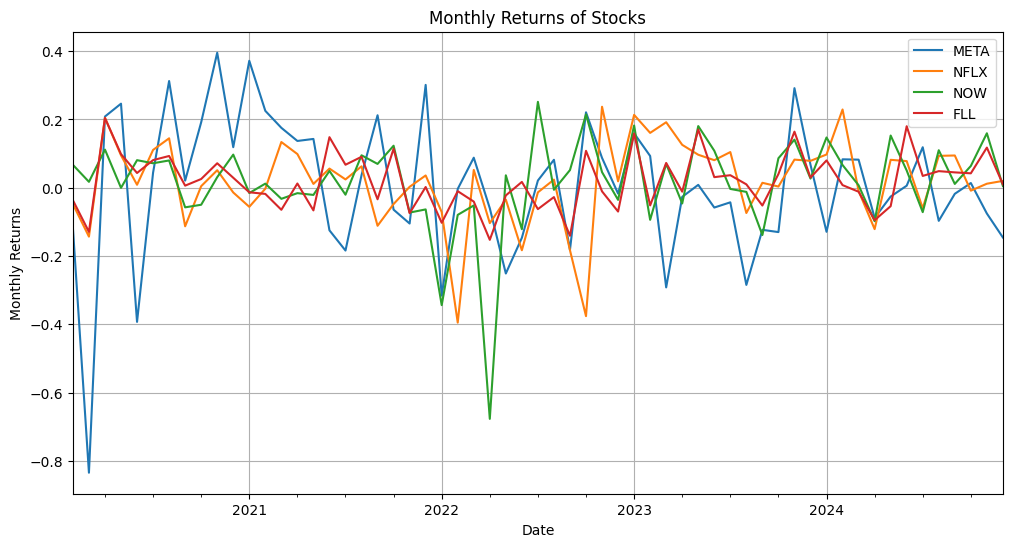

In [4]:
#import all 4 stocks 

stocks = ['META', 'NFLX', 'NOW', 'FLL']
df = yf.download(stocks, start='2020-01-01', end='2025-01-01')
# Resample to monthly frequency
df = df['Close'].resample('M').last()
# Calculate monthly returns
monthly_returns = df.pct_change().dropna()
log_returns = np.log(monthly_returns + 1)
#plot the heatmap
plt.figure(figsize=(10, 8))
sn.heatmap(monthly_returns.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Monthly Returns Correlation Heatmap')
plt.show()

#plot the returns of each stock
log_returns.plot(figsize=(12, 6))
plt.title('Monthly Returns of Stocks')
plt.xlabel('Date')
plt.ylabel('Monthly Returns')
plt.legend(stocks)
plt.grid()
plt.show()

[*********************100%***********************]  4 of 4 completed
/var/folders/b1/p4nglr2j4tldllw81z_d3c4c0000gn/T/ipykernel_39725/710475586.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').last()


Mean Squared Error: 0.0320


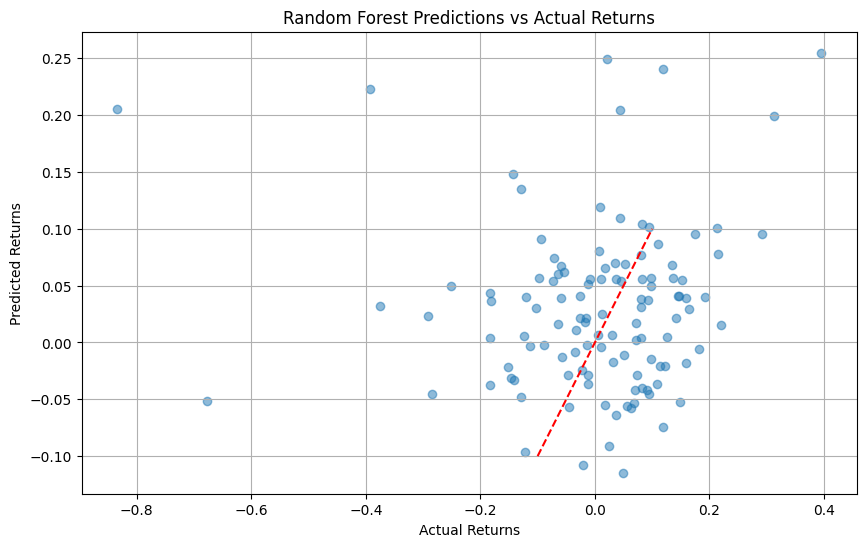

Ticker       FLL      META      NFLX       NOW
Date                                          
2      -0.033858  0.062614 -0.029797 -0.003707
3      -0.042125  0.056930 -0.026860 -0.001609
4      -0.035046  0.053671 -0.028193 -0.005208
5      -0.027866  0.060950 -0.014141  0.003077
6      -0.034490  0.050673 -0.034480 -0.009614
7       0.020762  0.096368 -0.005263  0.002741
8       0.033440  0.096311  0.003533  0.009250
9       0.030946  0.103141  0.011676  0.024795
10      0.071600  0.093503  0.026032  0.026864
11      0.061379  0.091188  0.017979  0.039203
12      0.014552  0.071494 -0.020752  0.031494


<Figure size 1200x600 with 0 Axes>

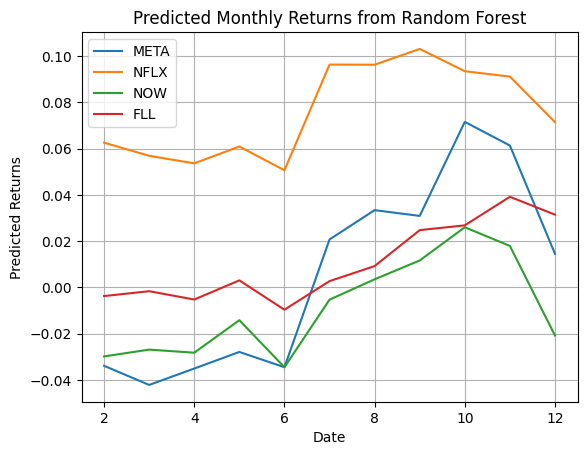

In [5]:
#set random forest parameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Prepare the data for Random Forest

stocks = ['META', 'NFLX', 'NOW', 'FLL']
df = yf.download(stocks, start='2020-01-01', end='2025-01-01')['Close']
df = df.resample('M').last()
monthly_returns = df.pct_change().dropna()
log_returns = np.log(monthly_returns + 1)
price_series = df

X = price_series.shift(1).dropna().values
y = log_returns.shift(-1).dropna().values

# realigning matrices
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
# Make predictions
y_pred = rf_model.predict(X_test)
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
# Plot the predictions vs actual returns
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], color='red', linestyle='--')
plt.title('Random Forest Predictions vs Actual Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.grid()
plt.show()

#get predicted pooled returns
price_series_aggregated = price_series.groupby(price_series.index.month).mean()

predicted_returns = rf_model.predict(price_series_aggregated.shift(1).dropna().values)

# Align predicted returns with the correct index and columns
predicted_returns = pd.DataFrame(predicted_returns, index=price_series_aggregated.index[1:], columns=price_series.columns)
print(predicted_returns)
plt.figure(figsize=(12, 6))
predicted_returns.plot()
plt.title('Predicted Monthly Returns from Random Forest')
plt.xlabel('Date')
plt.ylabel('Predicted Returns')
plt.legend(stocks)
plt.grid()
plt.show()


Feature Importances (sorted):
  Stock  Importance
0   FLL    0.527388
1  META    0.165541
2  NFLX    0.162031
3   NOW    0.145040


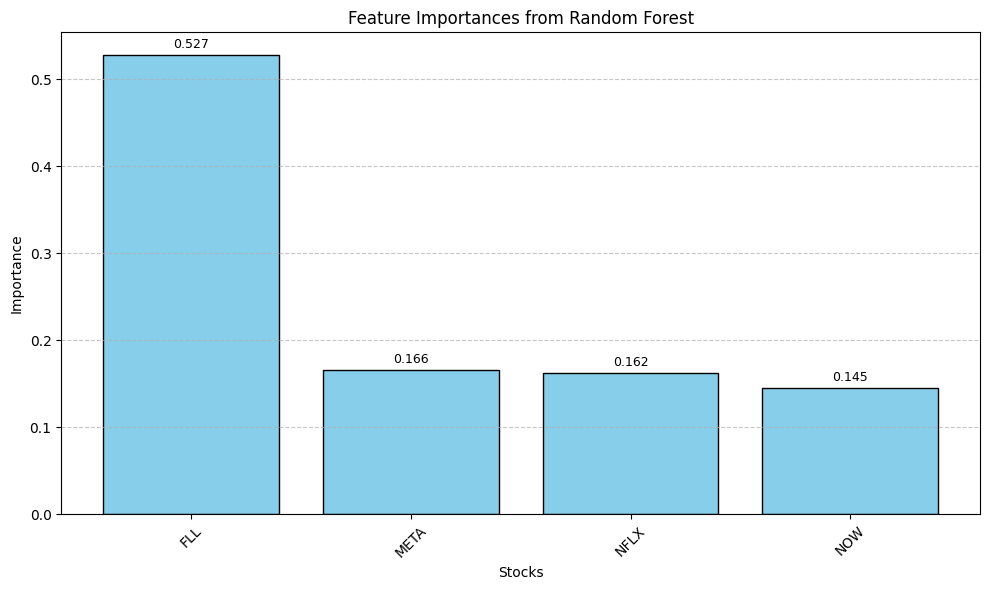

In [22]:
# Improved feature importance matrix visualization and debug output

importances = rf_model.feature_importances_
feature_names = price_series.columns

# Create a DataFrame for better inspection and sorting
importance_df = pd.DataFrame({
    'Stock': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the importance matrix for debugging
print("Feature Importances (sorted):")
print(importance_df)

# Enhanced bar plot with value annotations
plt.figure(figsize=(10, 6))
bars = plt.bar(importance_df['Stock'], importance_df['Importance'], color='skyblue', edgecolor='black')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Stocks')
plt.ylabel('Importance')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with importance values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error (Neural Network): 0.2955


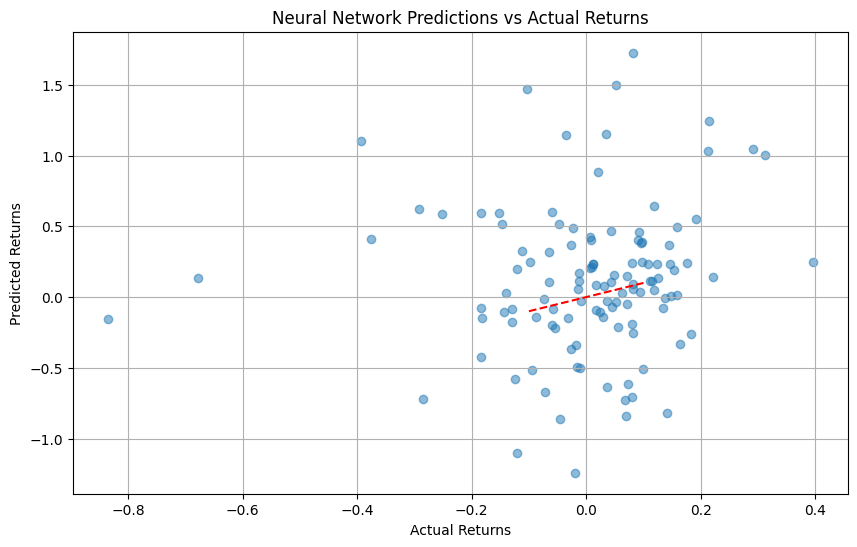

In [7]:
#set neural netwwork with parameteres to get arbitrage period which shows price spike 
from sklearn.neural_network import MLPRegressor
# Prepare the data for Neural Network
X_nn = price_series.shift(1).dropna().values
y_nn = log_returns.shift(-1).dropna().values
# Realigning matrices
min_length_nn = min(len(X_nn), len(y_nn))
X_nn = X_nn[:min_length_nn]
y_nn = y_nn[:min_length_nn]
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
	X_nn, y_nn, test_size=0.5, random_state=42
)
# Train the Neural Network model
nn_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=0)
nn_model.fit(X_train_nn, y_train_nn)
# Make predictions
y_pred_nn = nn_model.predict(X_test_nn)
# Calculate the mean squared error
mse_nn = mean_squared_error(y_test_nn, y_pred_nn)
print(f'Mean Squared Error (Neural Network): {mse_nn:.4f}')
# Plot the predictions vs actual returns
plt.figure(figsize=(10, 6))
plt.scatter(y_test_nn, y_pred_nn, alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], color='red', linestyle='--')
plt.title('Neural Network Predictions vs Actual Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.grid()
plt.show()

In [8]:
#Set optimal portfolio weights based on the predicted returns USING MARKOVITZ
from scipy.optimize import minimize

muh = price_series.mean()
sigma = price_series.cov()
def portfolio_variance(weights, sigma):
    return np.dot(weights.T, np.dot(sigma, weights))

weights_initial = np.array([1/len(stocks)] * len(stocks))
def objective_function(weights, mu, sigma):
    return -np.dot(weights, mu) / np.sqrt(portfolio_variance(weights, sigma)) #muh*weight/sigma
def constraint_sum(weights):
    return np.sum(weights) - 1
# Constraints and bounds
constraints = {'type': 'eq', 'fun': constraint_sum}
bounds = tuple((0, 1) for _ in range(len(stocks)))
# Optimize the portfolio weights
result = minimize(objective_function, weights_initial, args=(muh, sigma), method='SLSQP', bounds=bounds, constraints=constraints) #Assign convex optimiser
optimal_weights = result.x
print(f'Optimal Weights: {optimal_weights}')
#print stock names and their corresponding weights
for stock, weight in zip(stocks, optimal_weights):
    print(f'{stock}: {weight:.4f}')

Optimal Weights: [9.74829890e-01 3.49281252e-13 1.07506477e-02 1.44194623e-02]
META: 0.9748
NFLX: 0.0000
NOW: 0.0108
FLL: 0.0144


[*********************100%***********************]  4 of 4 completed


=== Enhanced Neural Network with Politician Parameters ===
Features per stock: 7 (3 price periods + 4 politician parameters)
Total training samples: 82
Total test samples: 36
Enhanced MLP Train R²: 0.0413
Enhanced MLP Test R²: -0.2052

=== Comparison with Baseline Model ===
Baseline MLP Train R²: -0.0693
Baseline MLP Test R²: -0.0723
Improvement in Test R²: -0.1329

=== Politician Parameter Analysis ===
Politician encodings:
  John McGuire: 0
  Susie Lee: 1

Party encodings:
  Democratic: 0
  Republican: 1

Sector encodings:
  Gaming: 0
  Technology: 1

Volume encodings:
  1K-5K: 0
  Low: 1


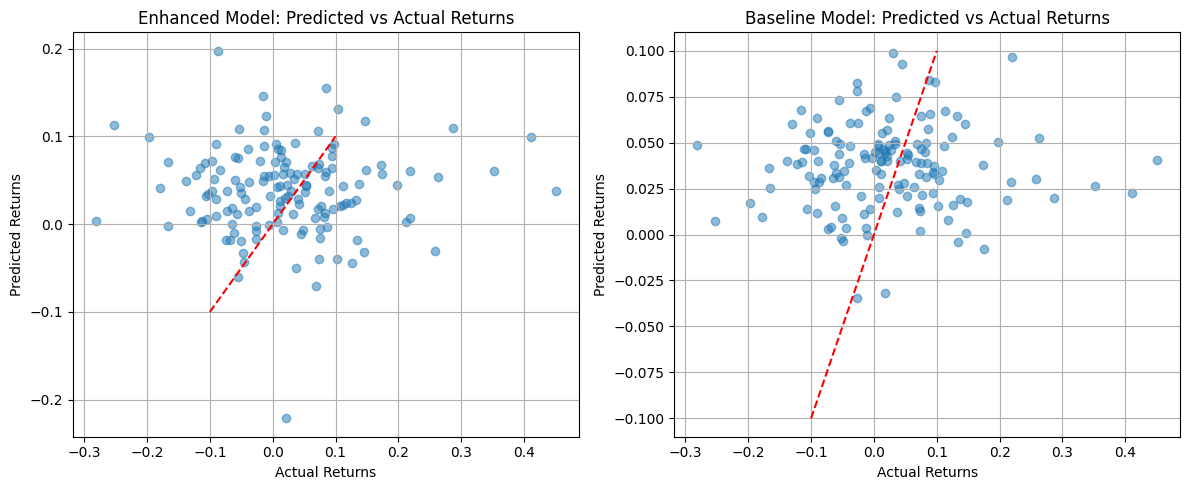


=== Next Period Predictions with Politician Context ===
META (John McGuire, Republican, Technology): 0.0294
NFLX (John McGuire, Republican, Technology): -0.0044
NOW (John McGuire, Republican, Technology): 0.0298
FLL (Susie Lee, Democratic, Gaming): 0.0435

=== Cross-Validation Results ===
Cross-validation R² scores: ['0.0003', '-0.5009', '-0.3229', '-0.6625', '-0.3425']
Mean CV R²: -0.3657 ± 0.2203


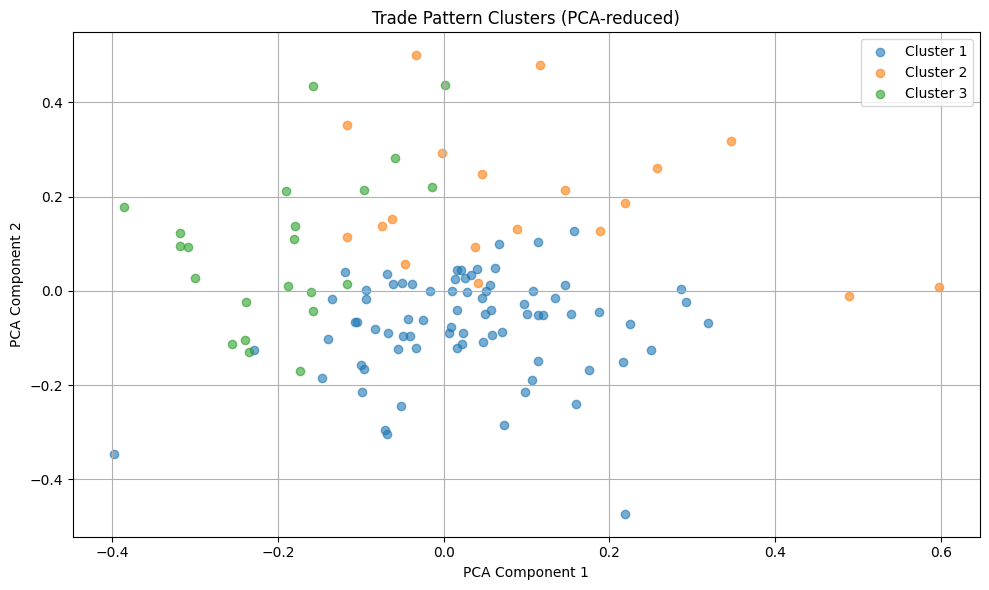


=== Cluster Composition by Time Period ===
Cluster 1: 77 samples
Cluster 2: 19 samples
Cluster 3: 22 samples

Cluster 1 mean returns per stock:
  META: 0.0123
  NFLX: 0.0099
  NOW: 0.0295
  FLL: 0.0260

Cluster 2 mean returns per stock:
  META: -0.0143
  NFLX: 0.0207
  NOW: 0.0348
  FLL: 0.0191

Cluster 3 mean returns per stock:
  META: 0.0857
  NFLX: 0.0653
  NOW: 0.0250
  FLL: 0.0335


In [21]:
# Incorporate all politician parameters into neural network
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import numpy as np

# Define stock information with politician parameters
stock_info_dictionary = {
    'META': {'politician': 'John McGuire', 'party': 'Republican', 'sector': 'Technology', 'volume': '1K-5K'},
    'NFLX': {'politician': 'John McGuire', 'party': 'Republican', 'sector': 'Technology', 'volume': '1K-5K'}, #add dates traded
    'NOW': {'politician': 'John McGuire', 'party': 'Republican', 'sector': 'Technology', 'volume': '1K-5K'},
    'FLL': {'politician': 'Susie Lee', 'party': 'Democratic', 'sector': 'Gaming', 'volume': 'Low'}
}

# Download and preprocess stock data
df = yf.download(stocks, start='2015-01-01', end='2025-01-01')['Close'].resample('ME').last()
price_series = df.pct_change().dropna()

# Create politician parameter encoders
politician_encoder = LabelEncoder()
party_encoder = LabelEncoder()
sector_encoder = LabelEncoder()
volume_encoder = LabelEncoder()

# Extract unique values for encoding
politicians = [info['politician'] for info in stock_info_dictionary.values()]
parties = [info['party'] for info in stock_info_dictionary.values()]
sectors = [info['sector'] for info in stock_info_dictionary.values()]
volumes = [info['volume'] for info in stock_info_dictionary.values()]

# Fit encoders
politician_encoder.fit(politicians)
party_encoder.fit(parties)
sector_encoder.fit(sectors)
volume_encoder.fit(volumes)

# Create enhanced feature matrix with politician parameters
def create_enhanced_features(price_data, stock_info_dict):
    """
    Create enhanced feature matrix combining stock price data with politician parameters
    """
    enhanced_features = []
    
    for stock in price_data.columns:
        if stock in stock_info_dict:
            # Get politician info for this stock
            info = stock_info_dict[stock]
            
            # Encode politician parameters
            politician_encoded = politician_encoder.transform([info['politician']])[0]
            party_encoded = party_encoder.transform([info['party']])[0]
            sector_encoded = sector_encoder.transform([info['sector']])[0]
            volume_encoded = volume_encoder.transform([info['volume']])[0]
            
            # Create feature vector for each time period
            for i in range(len(price_data)):
                # Stock price features (last 3 periods for trend)
                price_features = []
                for j in range(3):
                    if i - j >= 0:
                        price_features.append(price_data.iloc[i-j][stock])
                    else:
                        price_features.append(0)  # Padding for early periods
                
                # Combine price features with politician features
                combined_features = price_features + [
                    politician_encoded,
                    party_encoded, 
                    sector_encoded,
                    volume_encoded
                ]
                
                enhanced_features.append(combined_features)
    
    return np.array(enhanced_features)

# Create enhanced features
X_enhanced = create_enhanced_features(price_series, stock_info_dictionary)

# Prepare target variable (next period returns)
y_enhanced = price_series.values[1:]  # Shift by 1 to predict next period
X_enhanced = X_enhanced[:-1]  # Remove last row since we don't have next period data

# Ensure same length
min_length = min(len(X_enhanced), len(y_enhanced))
X_enhanced = X_enhanced[:min_length]
y_enhanced = y_enhanced[:min_length]

# Split data
X_train_enhanced, X_test_enhanced, y_train_enhanced, y_test_enhanced = train_test_split(
    X_enhanced, y_enhanced, test_size=0.3, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enhanced)
X_test_scaled = scaler.transform(X_test_enhanced)

# Train enhanced neural network
mlp_enhanced = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32), 
    activation='relu', 
    solver='adam', 
    max_iter=1000, 
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

mlp_enhanced.fit(X_train_scaled, y_train_enhanced)

# Evaluate enhanced model
train_score_enhanced = mlp_enhanced.score(X_train_scaled, y_train_enhanced)
test_score_enhanced = mlp_enhanced.score(X_test_scaled, y_test_enhanced)

print("=== Enhanced Neural Network with Politician Parameters ===")
print(f"Features per stock: {X_enhanced.shape[1]} (3 price periods + 4 politician parameters)")
print(f"Total training samples: {X_train_enhanced.shape[0]}")
print(f"Total test samples: {X_test_enhanced.shape[0]}")
print(f"Enhanced MLP Train R²: {train_score_enhanced:.4f}")
print(f"Enhanced MLP Test R²: {test_score_enhanced:.4f}")

# Compare with baseline model (price data only)
X_baseline = price_series.shift(1).dropna().values
y_baseline = price_series.iloc[1:].values

X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(
    X_baseline, y_baseline, test_size=0.3, random_state=42
)

mlp_baseline = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp_baseline.fit(X_train_baseline, y_train_baseline)

baseline_train_score = mlp_baseline.score(X_train_baseline, y_train_baseline)
baseline_test_score = mlp_baseline.score(X_test_baseline, y_test_baseline)

print("\n=== Comparison with Baseline Model ===")
print(f"Baseline MLP Train R²: {baseline_train_score:.4f}")
print(f"Baseline MLP Test R²: {baseline_test_score:.4f}")
print(f"Improvement in Test R²: {test_score_enhanced - baseline_test_score:.4f}")

# Feature importance analysis for politician parameters
print("\n=== Politician Parameter Analysis ===")
print("Politician encodings:")
for i, politician in enumerate(politician_encoder.classes_):
    print(f"  {politician}: {i}")

print("\nParty encodings:")
for i, party in enumerate(party_encoder.classes_):
    print(f"  {party}: {i}")

print("\nSector encodings:")
for i, sector in enumerate(sector_encoder.classes_):
    print(f"  {sector}: {i}")

print("\nVolume encodings:")
for i, volume in enumerate(volume_encoder.classes_):
    print(f"  {volume}: {i}")

# Plot predictions vs actual returns for enhanced model
predicted_enhanced = mlp_enhanced.predict(X_test_scaled)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_enhanced.flatten(), predicted_enhanced.flatten(), alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], color='red', linestyle='--')
plt.title('Enhanced Model: Predicted vs Actual Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.grid()

plt.subplot(1, 2, 2)
predicted_baseline = mlp_baseline.predict(X_test_baseline)
plt.scatter(y_test_baseline.flatten(), predicted_baseline.flatten(), alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], color='red', linestyle='--')
plt.title('Baseline Model: Predicted vs Actual Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.grid()

plt.tight_layout()
plt.show()

# Predict next period returns with politician context
print("\n=== Next Period Predictions with Politician Context ===")
latest_features = X_enhanced[-1:]  # Get latest features
latest_features_scaled = scaler.transform(latest_features)
next_predictions = mlp_enhanced.predict(latest_features_scaled)

for i, stock in enumerate(stocks):
    if stock in stock_info_dictionary:
        info = stock_info_dictionary[stock]
        print(f"{stock} ({info['politician']}, {info['party']}, {info['sector']}): {next_predictions[0][i]:.4f}")
    else:
        print(f"{stock}: {next_predictions[0][i]:.4f}")

# Cross-validation with politician parameters
print("\n=== Cross-Validation Results ===")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in kf.split(X_enhanced):
    X_cv_train, X_cv_val = X_enhanced[train_idx], X_enhanced[val_idx]
    y_cv_train, y_cv_val = y_enhanced[train_idx], y_enhanced[val_idx]
    
    # Scale features
    cv_scaler = StandardScaler()
    X_cv_train_scaled = cv_scaler.fit_transform(X_cv_train)
    X_cv_val_scaled = cv_scaler.transform(X_cv_val)
    
    # Train model
    cv_model = MLPRegressor(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42)
    cv_model.fit(X_cv_train_scaled, y_cv_train)
    
    # Evaluate
    cv_score = cv_model.score(X_cv_val_scaled, y_cv_val)
    cv_scores.append(cv_score)

print(f"Cross-validation R² scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean CV R²: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")




# apply clustering to get trade patterns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# We'll use the enhanced features (with politician context) for clustering
n_clusters = 3  # You can adjust this based on your analysis

# Reduce dimensionality for visualization (optional, but helpful)
#define PCA components
n_components = 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_enhanced)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_enhanced)

# Visualize clusters in PCA-reduced space
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    plt.scatter(
        X_pca[clusters == cluster, 0],
        X_pca[clusters == cluster, 1],
        label=f'Cluster {cluster+1}',
        alpha=0.6
    )
plt.title('Trade Pattern Clusters (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Analyze cluster composition
import collections
print("\n=== Cluster Composition by Time Period ===")
cluster_counts = collections.Counter(clusters)
for cluster in range(n_clusters):
    print(f"Cluster {cluster+1}: {cluster_counts[cluster]} samples")

# Optionally, examine average returns per cluster
cluster_returns = []
for cluster in range(n_clusters):
    mean_return = y_enhanced[clusters == cluster].mean(axis=0)
    cluster_returns.append(mean_return)
    print(f"\nCluster {cluster+1} mean returns per stock:")
    for i, stock in enumerate(stocks):
        print(f"  {stock}: {mean_return[i]:.4f}")


[*********************100%***********************]  4 of 4 completed


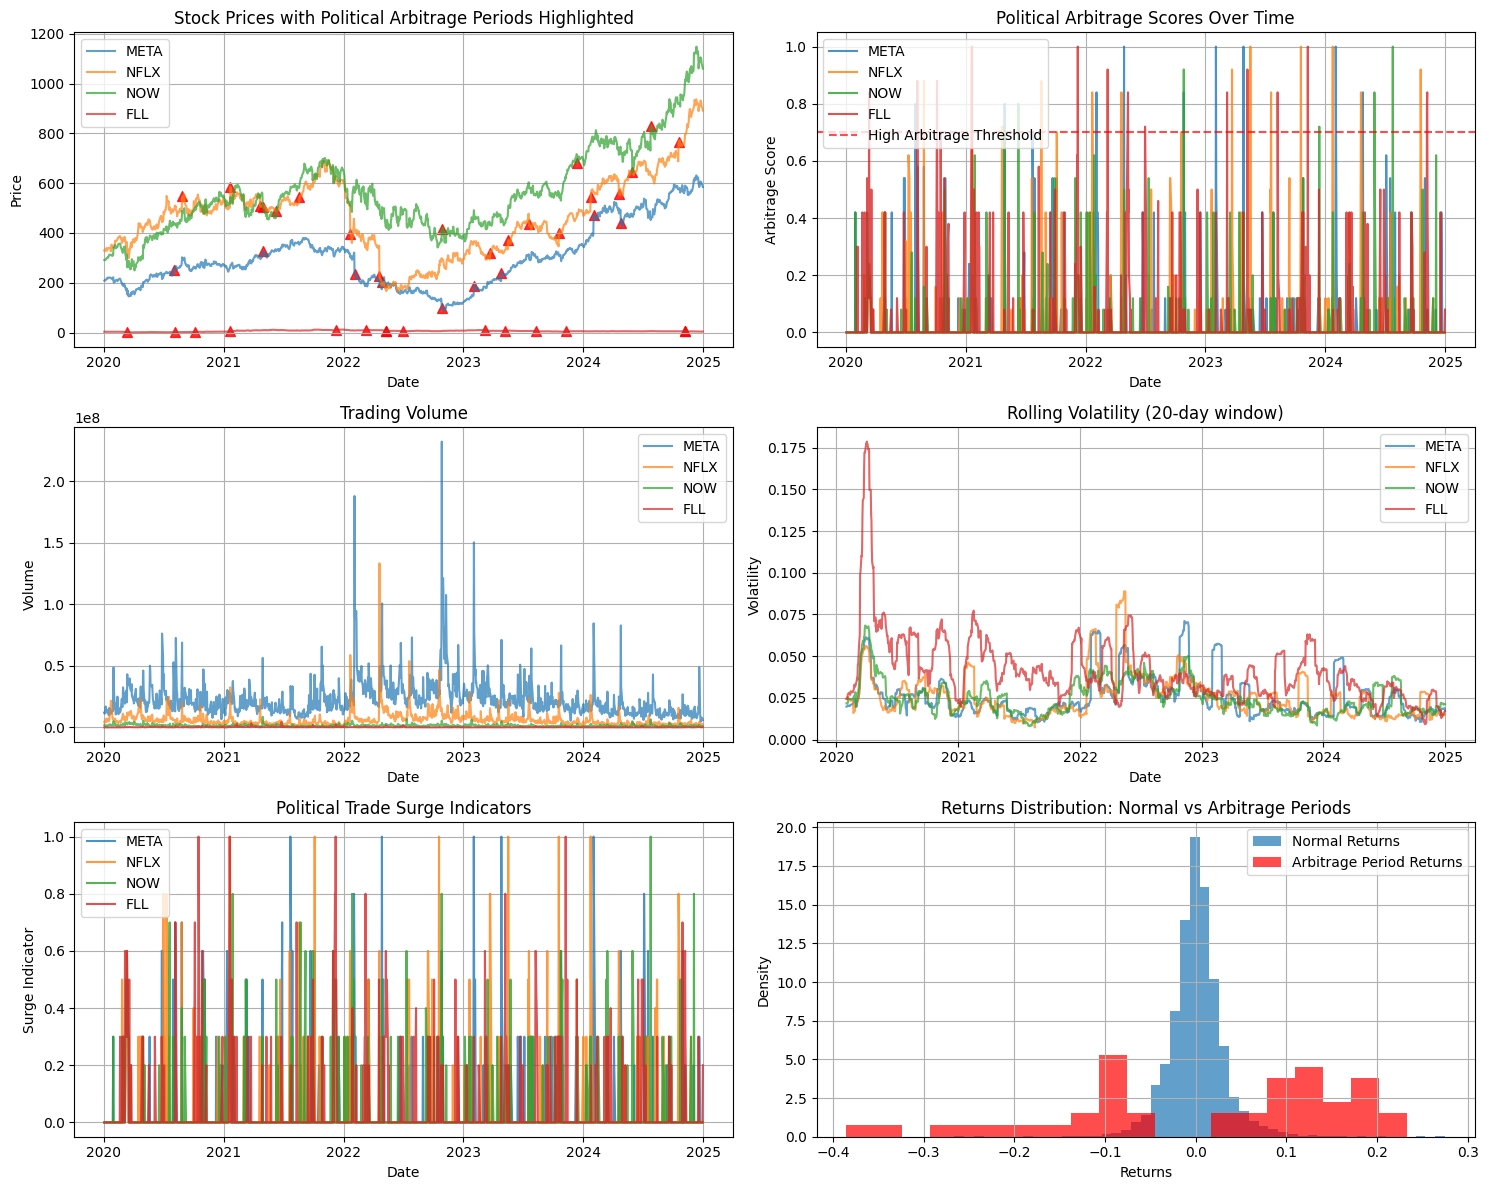

=== POLITICAL ARBITRAGE OPPORTUNITY ANALYSIS ===

META - Political Arbitrage Opportunities:
  Number of arbitrage periods: 9
  Average arbitrage score: 0.0329
  Max arbitrage score: 1.0000
  Average return during arbitrage: 0.0323
  Volatility during arbitrage: 0.1902
  Top 3 arbitrage periods:
    2022-04-28: Score=1.0000, Return=0.1759, Volume=100,890,600
    2023-02-02: Score=1.0000, Return=0.2328, Volume=150,475,700
    2023-04-27: Score=1.0000, Return=0.1393, Volume=71,196,500

NFLX - Political Arbitrage Opportunities:
  Number of arbitrage periods: 13
  Average arbitrage score: 0.0359
  Max arbitrage score: 1.0000
  Average return during arbitrage: 0.0053
  Volatility during arbitrage: 0.1584
  Top 3 arbitrage periods:
    2021-01-20: Score=1.0000, Return=0.1685, Volume=32,637,500
    2023-05-18: Score=1.0000, Return=0.0922, Volume=20,925,200
    2023-10-19: Score=1.0000, Return=0.1605, Volume=28,074,400

NOW - Political Arbitrage Opportunities:
  Number of arbitrage periods: 6
 

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [20]:
# Advanced Arbitrage Detection for Political Trade Surges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
import yfinance as yf

# Enhanced arbitrage detection for political trade surges
def detect_political_arbitrage_opportunities(stocks, start_date='2020-01-01', end_date='2025-01-01'):
    """
    Detect arbitrage opportunities caused by political trade surges
    """
    # Download comprehensive data including volume
    df = yf.download(stocks, start=start_date, end=end_date)
    
    # Calculate various metrics
    price_data = df['Close']
    volume_data = df['Volume']
    returns = price_data.pct_change().dropna()
    
    # Calculate rolling statistics for anomaly detection
    window = 20  # 20-day rolling window
    
    # 1. Volatility spikes (sudden increases in price volatility)
    rolling_volatility = returns.rolling(window=window).std()
    volatility_threshold = rolling_volatility.rolling(window=window).mean() + 2 * rolling_volatility.rolling(window=window).std()
    volatility_spikes = rolling_volatility > volatility_threshold
    
    # 2. Volume surges (unusual trading volume)
    rolling_volume = volume_data.rolling(window=window).mean()
    volume_threshold = rolling_volume + 2 * volume_data.rolling(window=window).std()
    volume_surges = volume_data > volume_threshold
    
    # 3. Price momentum (sudden price movements)
    price_momentum = returns.rolling(window=5).sum()  # 5-day momentum
    momentum_threshold = price_momentum.rolling(window=window).mean() + 2 * price_momentum.rolling(window=window).std()
    momentum_spikes = price_momentum > momentum_threshold
    
    # 4. Cross-stock correlation breakdown (arbitrage opportunity indicator)
    rolling_corr = returns.rolling(window=window).corr()
    avg_correlation = rolling_corr.groupby(level=0).mean()
    correlation_breakdown = avg_correlation < avg_correlation.rolling(window=window).mean() - avg_correlation.rolling(window=window).std()
    
    # 5. Political trade surge detection
    political_surge_indicators = pd.DataFrame(index=returns.index)
    
    for stock in stocks:
        # Combine multiple indicators for political surge detection
        stock_indicators = (
            volatility_spikes[stock] * 0.3 +
            volume_surges[stock] * 0.3 +
            momentum_spikes[stock] * 0.2 +
            (returns[stock] > returns[stock].rolling(window=window).mean() + 2 * returns[stock].rolling(window=window).std()) * 0.2
        )
        political_surge_indicators[stock] = stock_indicators
    
    # 6. Arbitrage opportunity scoring
    arbitrage_scores = pd.DataFrame(index=returns.index)
    
    for stock in stocks:
        # Calculate arbitrage score based on multiple factors
        score = (
            political_surge_indicators[stock] * 0.4 +
            (returns[stock].abs() > returns[stock].rolling(window=window).std() * 3) * 0.3 +
            (volume_data[stock] > volume_data[stock].rolling(window=window).mean() * 2) * 0.3
        )
        arbitrage_scores[stock] = score
    
    # 7. Identify high-probability arbitrage periods
    high_arbitrage_periods = arbitrage_scores > 0.7  # Threshold for high probability
    
    return {
        'returns': returns,
        'volume_data': volume_data,
        'volatility_spikes': volatility_spikes,
        'volume_surges': volume_surges,
        'momentum_spikes': momentum_spikes,
        'political_surge_indicators': political_surge_indicators,
        'arbitrage_scores': arbitrage_scores,
        'high_arbitrage_periods': high_arbitrage_periods,
        'price_data': price_data
    }

# Apply the detection
arbitrage_results = detect_political_arbitrage_opportunities(stocks)

# Visualize results
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 1. Price movements with arbitrage periods highlighted
for i, stock in enumerate(stocks):
    axes[0, 0].plot(arbitrage_results['price_data'].index, arbitrage_results['price_data'][stock], 
                    label=stock, alpha=0.7)
    
    # Highlight arbitrage periods
    arbitrage_dates = arbitrage_results['high_arbitrage_periods'][arbitrage_results['high_arbitrage_periods'][stock]].index
    if len(arbitrage_dates) > 0:
        arbitrage_prices = arbitrage_results['price_data'].loc[arbitrage_dates, stock]
        axes[0, 0].scatter(arbitrage_dates, arbitrage_prices, color='red', s=50, alpha=0.8, marker='^')

axes[0, 0].set_title('Stock Prices with Political Arbitrage Periods Highlighted')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price')
axes[0, 0].legend()
axes[0, 0].grid(True)

# 2. Arbitrage scores over time
for stock in stocks:
    axes[0, 1].plot(arbitrage_results['arbitrage_scores'].index, arbitrage_results['arbitrage_scores'][stock], 
                    label=stock, alpha=0.8)
axes[0, 1].axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='High Arbitrage Threshold')
axes[0, 1].set_title('Political Arbitrage Scores Over Time')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Arbitrage Score')
axes[0, 1].legend()
axes[0, 1].grid(True)

# 3. Volume surges
for stock in stocks:
    axes[1, 0].plot(arbitrage_results['volume_data'].index, arbitrage_results['volume_data'][stock], 
                    label=stock, alpha=0.7)
axes[1, 0].set_title('Trading Volume')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Volume')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 4. Volatility spikes
for stock in stocks:
    rolling_vol = arbitrage_results['returns'][stock].rolling(window=20).std()
    axes[1, 1].plot(rolling_vol.index, rolling_vol, label=stock, alpha=0.7)
axes[1, 1].set_title('Rolling Volatility (20-day window)')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Volatility')
axes[1, 1].legend()
axes[1, 1].grid(True)

# 5. Political surge indicators
for stock in stocks:
    axes[2, 0].plot(arbitrage_results['political_surge_indicators'].index, 
                    arbitrage_results['political_surge_indicators'][stock], 
                    label=stock, alpha=0.8)
axes[2, 0].set_title('Political Trade Surge Indicators')
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('Surge Indicator')
axes[2, 0].legend()
axes[2, 0].grid(True)

# 6. Returns distribution with arbitrage periods
all_returns = arbitrage_results['returns'].values.flatten()
arbitrage_returns = []
normal_returns = []

for stock in stocks:
    stock_returns = arbitrage_results['returns'][stock]
    arbitrage_dates = arbitrage_results['high_arbitrage_periods'][arbitrage_results['high_arbitrage_periods'][stock]].index
    
    for date in stock_returns.index:
        if date in arbitrage_dates:
            arbitrage_returns.append(stock_returns[date])
        else:
            normal_returns.append(stock_returns[date])

axes[2, 1].hist(normal_returns, bins=50, alpha=0.7, label='Normal Returns', density=True)
axes[2, 1].hist(arbitrage_returns, bins=20, alpha=0.7, label='Arbitrage Period Returns', density=True, color='red')
axes[2, 1].set_title('Returns Distribution: Normal vs Arbitrage Periods')
axes[2, 1].set_xlabel('Returns')
axes[2, 1].set_ylabel('Density')
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()

# Print detailed arbitrage analysis
print("=== POLITICAL ARBITRAGE OPPORTUNITY ANALYSIS ===")

# Summary statistics
for stock in stocks:
    arbitrage_dates = arbitrage_results['high_arbitrage_periods'][arbitrage_results['high_arbitrage_periods'][stock]].index
    if len(arbitrage_dates) > 0:
        print(f"\n{stock} - Political Arbitrage Opportunities:")
        print(f"  Number of arbitrage periods: {len(arbitrage_dates)}")
        print(f"  Average arbitrage score: {arbitrage_results['arbitrage_scores'][stock].mean():.4f}")
        print(f"  Max arbitrage score: {arbitrage_results['arbitrage_scores'][stock].max():.4f}")
        
        # Calculate returns during arbitrage periods
        arbitrage_returns_stock = arbitrage_results['returns'].loc[arbitrage_dates, stock]
        print(f"  Average return during arbitrage: {arbitrage_returns_stock.mean():.4f}")
        print(f"  Volatility during arbitrage: {arbitrage_returns_stock.std():.4f}")
        
        # Show top arbitrage periods
        top_periods = arbitrage_results['arbitrage_scores'][stock].nlargest(3)
        print(f"  Top 3 arbitrage periods:")
        for date, score in top_periods.items():
            return_val = arbitrage_results['returns'].loc[date, stock]
            volume_val = arbitrage_results['volume_data'].loc[date, stock]
            print(f"    {date.strftime('%Y-%m-%d')}: Score={score:.4f}, Return={return_val:.4f}, Volume={volume_val:,.0f}")

# Export arbitrage opportunities to CSV
arbitrage_export = pd.DataFrame()
for stock in stocks:
    stock_arbitrage = arbitrage_results['high_arbitrage_periods'][arbitrage_results['high_arbitrage_periods'][stock]]
    if stock_arbitrage.any():
        dates = stock_arbitrage[stock_arbitrage].index
        scores = arbitrage_results['arbitrage_scores'].loc[dates, stock]
        returns = arbitrage_results['returns'].loc[dates, stock]
        volumes = arbitrage_results['volume_data'].loc[dates, stock]
        
        stock_df = pd.DataFrame({
            'Stock': stock,
            'Date': dates,
            'Arbitrage_Score': scores,
            'Return': returns,
            'Volume': volumes
        })
        arbitrage_export = pd.concat([arbitrage_export, stock_df])

if not arbitrage_export.empty:
    arbitrage_export = arbitrage_export.sort_values('Arbitrage_Score', ascending=False)
    arbitrage_export.to_csv('political_arbitrage_opportunities.csv', index=False)
    print(f"\nExported {len(arbitrage_export)} arbitrage opportunities to 'political_arbitrage_opportunities.csv'")

# Real-time arbitrage monitoring function
def monitor_realtime_arbitrage(stocks, lookback_days=30):
    """
    Monitor for real-time arbitrage opportunities
    """
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.Timedelta(days=lookback_days)
    
    recent_data = detect_political_arbitrage_opportunities(stocks, start_date, end_date)
    
    print(f"\n=== REAL-TIME ARBITRAGE MONITORING ({start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}) ===")
    
    for stock in stocks:
        latest_score = recent_data['arbitrage_scores'][stock].iloc[-1]
        latest_return = recent_data['returns'][stock].iloc[-1]
        latest_volume = recent_data['volume_data'][stock].iloc[-1]
        
        status = "HIGH ARBITRAGE OPPORTUNITY" if latest_score > 0.7 else "Normal"
        print(f"{stock}: Score={latest_score:.4f}, Return={latest_return:.4f}, Volume={latest_volume:,.0f} - {status}")

# Run real-time monitoring
